# Theophilus Braimoh (tob2zd)
# 3/12/2023

# Recognizing UVA landmarks with neural nets (70 pts)
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture. 

In this assignment, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. You will earn 70 points for this assignment plus 10 bonus points if (1) your classifier performs exceed 94% accuracy.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_assignment_2.ipynb

Best of luck, and have fun! 

# Load Packages

In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image


import tensorflow as tf

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in my Firebase server. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

In [2]:
# Download dataset from FirebaseStorage
!pip install wget
!wget https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=b2f102052a58a948c3094094b7ec7400d90ccc7d998f1e6ba8afdc74c9af9f5f
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
--2023-03-13 03:03:25--  https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media
Resolving firebasestorage.googleapis.com (firebasestorage.googleapis.com)... 142.251.10.95, 142.251.12.95, 172.217.194.95, ...
Connecting to firebasestorage.googleapis.com (firebasestorage.googleapis.com)|142.251.10.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397174132 (379M) [application/zip]
Saving to: ‘dataset.zip?alt=media’

dataset.zip?alt=med 100%[===================>] 378.77M  24.0MB/s    in 17s     

2023-03-13 03:03

In [3]:
# Extract content
!unzip "/content/dataset.zip?alt=media"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Rotunda/0000010694.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010694.jpg  
  inflating: dataset/Rotunda/0000010680.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010680.jpg  
  inflating: dataset/Rotunda/0000010858.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010858.jpg  
  inflating: dataset/Rotunda/0000010870.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010870.jpg  
  inflating: dataset/Rotunda/0000010864.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010864.jpg  
  inflating: dataset/Rotunda/0000010865.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010865.jpg  
  inflating: dataset/Rotunda/0000010871.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010871.jpg  
  inflating: dataset/Rotunda/0000010859.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010859.jpg  
  inflating: dataset/Rotunda/0000010681.jpg  
  inflating: __MACOSX/dataset/Rotunda/._0000010681.jpg  
  inflating: dataset/R

In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/dataset/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 14286 files belonging to 18 classes.
Using 11429 files for training.
Found 14286 files belonging to 18 classes.
Using 2857 files for validation.


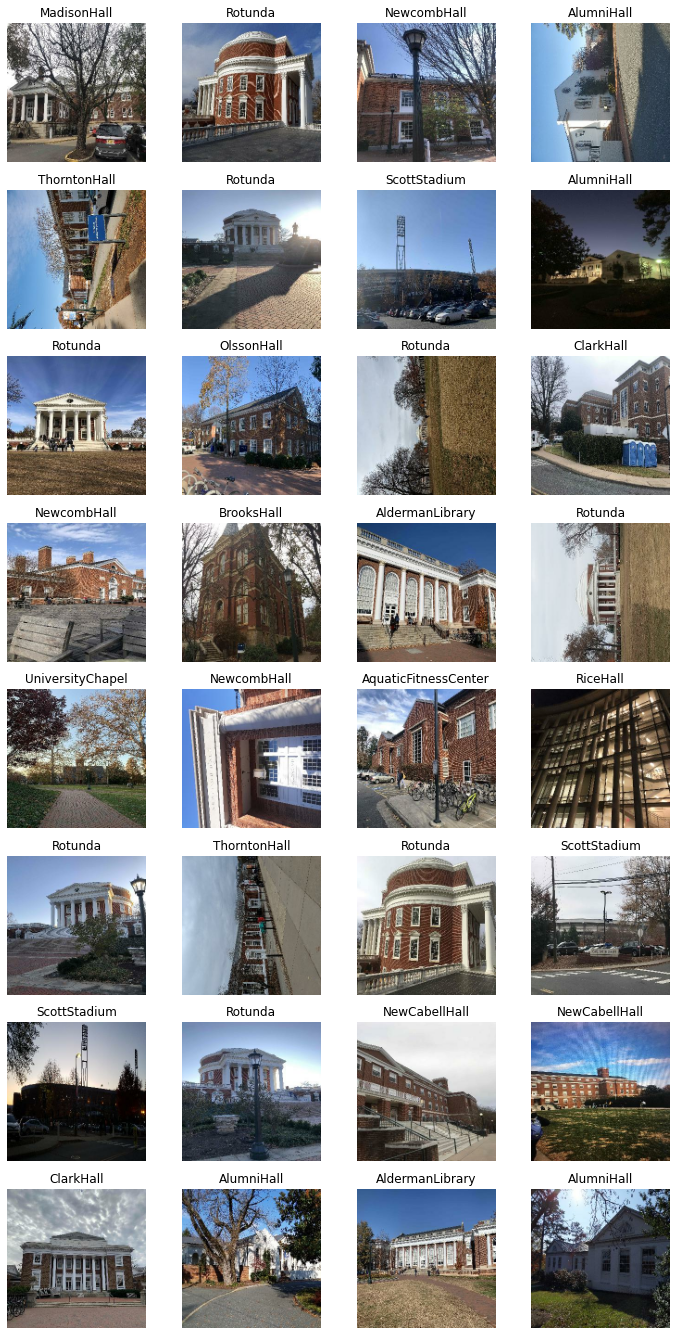

In [5]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter', 
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall', 
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium', 
  'ThorntonHall', 'UniversityChapel']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks. 

Best of luck!

In [6]:
# YOUR CODE STARTS HERE

In [7]:
num_classes = len(train_ds.class_names) 
print(f"Number of classes: {num_classes}") #18 classes as tated in problem title

Number of classes: 18


### Model 1

In [8]:
# Using pretrained ResNet50 from the Keras API: https://keras.io/api/applications/
# set include_top to false to remove the top layer with 1000 classes. Our dataset has 18 classes.
model_1_no_top = keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
model_1_with_top = keras.applications.resnet50.ResNet50(weights="imagenet") # you may also set include_top=True

102967424/102967424 [==============================] - 5s 0us/step


In [9]:
# Print the model architecture with the top layer included
model_1_with_top.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
# Print the model architecture without top layer
model_1_no_top.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [11]:
# Add new avg_pool_layer for aggregation of the "conv5_block3_out" layer. You can name it just "avg_pool", if you want.
avg_pool_layer = keras.layers.GlobalAveragePooling2D()(model_1_no_top.output)

In [12]:
# Verify the shape of the weights of the new avg_pool_layer conforms with the output of the "conv5_block3_out" layer
avg_pool_layer.shape

TensorShape([None, 2048])

In [13]:
# Add Fully connected output layer with the number of classes (18) in our dataset. Here we named it predictions, you may call it something else.
output_layer = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(avg_pool_layer)
output_layer.shape

TensorShape([None, 18])

In [14]:
model_1 = keras.models.Model(inputs=model_1_no_top.input, outputs=output_layer)

In [15]:
# Print the modified architecture
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [16]:
# Show the full index of the layers and choose where to start training from. You can see the convolution operations are in blocks. You want to train the entire block if you are choosing to train anyone
for index, layer in enumerate(model_1.layers):
  print(index, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

##### Fine-tuning the entire model on our dataset. This sometimes help to adapt it to our domain.

In [17]:
# Train the model
num_epochs = 5

# You may fine-tune the entire model, if you have time and compute resource. For that we don't need to freeze any layer.
for layer in model_1.layers: # These 2 lines are not really required since we are not indexing into the list of layers.
    layer.trainable = True

# Define the optimizer and set hyper-parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3, momentum=0.9)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_1.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)

Epoch 1/5
358/358 [==============================] - 44s 57ms/step - loss: 3.5222 - accuracy: 0.1102 - val_loss: 2.9178 - val_accuracy: 0.1306
Epoch 2/5
358/358 [==============================] - 19s 52ms/step - loss: 2.7528 - accuracy: 0.1238 - val_loss: 2.7884 - val_accuracy: 0.1222
Epoch 3/5
358/358 [==============================] - 19s 52ms/step - loss: 2.7281 - accuracy: 0.1318 - val_loss: 2.7866 - val_accuracy: 0.1414
Epoch 4/5
358/358 [==============================] - 19s 53ms/step - loss: 2.6972 - accuracy: 0.1422 - val_loss: 2.7220 - val_accuracy: 0.1197
Epoch 5/5
358/358 [==============================] - 19s 53ms/step - loss: 2.6597 - accuracy: 0.1424 - val_loss: 2.7006 - val_accuracy: 0.1348


##### Train only the final dense layer by indexing and freezing the other layers.

In [18]:
# Train the model
num_epochs = 5

# You may only We want to train the final layer that we just created. For this we freeze the other layers.
for layer in model_1.layers[:-1]:
    layer.trainable = False

# Define the optimizer and set hyper-parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3, momentum=0.9)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_1.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)

Epoch 1/5
358/358 [==============================] - 11s 23ms/step - loss: 2.5914 - accuracy: 0.1578 - val_loss: 2.5856 - val_accuracy: 0.1498
Epoch 2/5
358/358 [==============================] - 7s 20ms/step - loss: 2.5709 - accuracy: 0.1646 - val_loss: 2.6265 - val_accuracy: 0.1547
Epoch 3/5
358/358 [==============================] - 7s 19ms/step - loss: 2.5634 - accuracy: 0.1675 - val_loss: 2.5953 - val_accuracy: 0.1624
Epoch 4/5
358/358 [==============================] - 7s 20ms/step - loss: 2.5619 - accuracy: 0.1708 - val_loss: 2.5831 - val_accuracy: 0.1631
Epoch 5/5
358/358 [==============================] - 7s 19ms/step - loss: 2.5657 - accuracy: 0.1676 - val_loss: 2.5683 - val_accuracy: 0.1768


In [19]:
# Repeat for any other architecture that you choose from the API or create a custom architecture of your own.

# Model 2

In [20]:
# Using pretrained ResNet152V2 from the Keras API: https://keras.io/api/applications/
# set include_top to false to remove the top layer with 1000 classes. Our dataset has 18 classes.
model_2_no_top = keras.applications.ResNet152V2(weights="imagenet", include_top=False)
model_2_with_top = keras.applications.ResNet152V2(weights="imagenet") # you may also set include_top=True

242745792/242745792 [==============================] - 12s 0us/step


In [21]:
# Print the model architecture with the top layer included
model_2_with_top.summary()


Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [22]:
# Print the model architecture without top layer
model_2_no_top.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                     

In [23]:
# Add new avg_pool_layer for aggregation of the "conv5_block3_out" layer. You can name it just "avg_pool", if you want.
avg_pool_layer = keras.layers.GlobalAveragePooling2D()(model_2_no_top.output)

In [24]:
# Verify the shape of the weights of the new avg_pool_layer conforms with the output of the "conv5_block3_out" layer
avg_pool_layer.shape

TensorShape([None, 2048])

In [25]:
# Add Fully connected output layer with the number of classes (18) in our dataset. Here we named it predictions, you may call it something else.
output_layer = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(avg_pool_layer)
output_layer.shape

TensorShape([None, 18])

In [26]:
model_2 = keras.models.Model(inputs=model_2_no_top.input, outputs=output_layer)

In [27]:
# Train the model
num_epochs = 5

# You may fine-tune the entire model, if you have time and compute resource. For that we don't need to freeze any layer.
for layer in model_2.layers: # These 2 lines are not really required since we are not indexing into the list of layers.
    layer.trainable = True

# Define the optimizer and set hyper-parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2, use_ema=True, ema_momentum=0.8)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_2.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)

Epoch 1/5
358/358 [==============================] - 152s 171ms/step - loss: 5.4780 - accuracy: 0.1026 - val_loss: 41.6907 - val_accuracy: 0.1019
Epoch 2/5
358/358 [==============================] - 59s 164ms/step - loss: 2.8157 - accuracy: 0.1038 - val_loss: 3.9095 - val_accuracy: 0.1064
Epoch 3/5
358/358 [==============================] - 59s 164ms/step - loss: 2.8197 - accuracy: 0.1028 - val_loss: 3.5223 - val_accuracy: 0.1089
Epoch 4/5
358/358 [==============================] - 59s 163ms/step - loss: 2.8284 - accuracy: 0.0991 - val_loss: 2.9935 - val_accuracy: 0.1071
Epoch 5/5
358/358 [==============================] - 59s 164ms/step - loss: 2.8127 - accuracy: 0.1065 - val_loss: 5.4184 - val_accuracy: 0.0732


In [28]:
# Train the model
num_epochs = 5

# You may only We want to train the final layer that we just created. For this we freeze the other layers.
for layer in model_2.layers[:-1]:
    layer.trainable = False

# Define the optimizer and set hyper-parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.2, use_ema=True, ema_momentum=0.8)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_2.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)

Epoch 1/5
358/358 [==============================] - 28s 54ms/step - loss: 5.2733 - accuracy: 0.1030 - val_loss: 4.7947 - val_accuracy: 0.1113
Epoch 2/5
358/358 [==============================] - 17s 47ms/step - loss: 5.7284 - accuracy: 0.1071 - val_loss: 5.2256 - val_accuracy: 0.1103
Epoch 3/5
358/358 [==============================] - 17s 46ms/step - loss: 4.8148 - accuracy: 0.1130 - val_loss: 6.7038 - val_accuracy: 0.1103
Epoch 4/5
358/358 [==============================] - 17s 46ms/step - loss: 5.3419 - accuracy: 0.1063 - val_loss: 5.2191 - val_accuracy: 0.1148
Epoch 5/5
358/358 [==============================] - 17s 46ms/step - loss: 5.1645 - accuracy: 0.1138 - val_loss: 5.2425 - val_accuracy: 0.1169


# Model 3

In [29]:
# Using pretrained EfficientNetB4 from the Keras API: https://keras.io/api/applications/
# set include_top to false to remove the top layer with 1000 classes. Our dataset has 18 classes.
model_3_no_top = keras.applications.EfficientNetB4(weights="imagenet", include_top=False)
model_3_with_top = keras.applications.EfficientNetB4(weights="imagenet") # you may also set include_top=True

78864416/78864416 [==============================] - 5s 0us/step


In [30]:
# Print the model architecture with the top layer included
model_3_with_top.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 380, 380, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 380, 380, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [31]:
# Print the model architecture without top layer
model_3_no_top.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [32]:
# Add new avg_pool_layer for aggregation of the "conv5_block3_out" layer. You can name it just "avg_pool", if you want.
avg_pool_layer = keras.layers.GlobalAveragePooling2D()(model_3_no_top.output)

In [33]:
# Verify the shape of the weights of the new avg_pool_layer conforms with the output of the "conv5_block3_out" layer
avg_pool_layer.shape

TensorShape([None, 1792])

In [34]:
# Add Fully connected output layer with the number of classes (18) in our dataset. Here we named it predictions, you may call it something else.
output_layer = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(avg_pool_layer)
output_layer.shape

TensorShape([None, 18])

In [35]:
model_3 = keras.models.Model(inputs=model_3_no_top.input, outputs=output_layer)

In [36]:
# Train the model
num_epochs = 10

# You may fine-tune the entire model, if you have time and compute resource. For that we don't need to freeze any layer.
for layer in model_3.layers: # These 2 lines are not really required since we are not indexing into the list of layers.
    layer.trainable = True

# Define the optimizer and set hyper-parameters
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.3, momentum=0.9, decay=0.01)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_3.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)


Epoch 1/10
358/358 [==============================] - 50s 95ms/step - loss: 2.3894 - accuracy: 0.2862 - val_loss: 2.3015 - val_accuracy: 0.3119
Epoch 2/10
358/358 [==============================] - 31s 85ms/step - loss: 1.3510 - accuracy: 0.5931 - val_loss: 1.3132 - val_accuracy: 0.6069
Epoch 3/10
358/358 [==============================] - 31s 85ms/step - loss: 0.8637 - accuracy: 0.7479 - val_loss: 1.0549 - val_accuracy: 0.6955
Epoch 4/10
358/358 [==============================] - 31s 85ms/step - loss: 0.5927 - accuracy: 0.8266 - val_loss: 0.6623 - val_accuracy: 0.8232
Epoch 5/10
358/358 [==============================] - 31s 85ms/step - loss: 0.4046 - accuracy: 0.8801 - val_loss: 0.6232 - val_accuracy: 0.8341
Epoch 6/10
358/358 [==============================] - 31s 86ms/step - loss: 0.2756 - accuracy: 0.9179 - val_loss: 0.6099 - val_accuracy: 0.8484
Epoch 7/10
358/358 [==============================] - 31s 86ms/step - loss: 0.2043 - accuracy: 0.9361 - val_loss: 0.6662 - val_accuracy:

In [37]:
# Train the model
num_epochs = 10

# You may only We want to train the final layer that we just created. For this we freeze the other layers.
for layer in model_3.layers[:-1]:
    layer.trainable = False

# Define the optimizer and set hyper-parameters
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.3, momentum=0.9, decay=0.01)

# Specify loss based on the type of task. Here, we are dealing with a classification problem 
model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_3.fit(train_ds, validation_data = validation_ds,
                      epochs = num_epochs)

Epoch 1/10
358/358 [==============================] - 24s 36ms/step - loss: 0.0317 - accuracy: 0.9917 - val_loss: 0.6620 - val_accuracy: 0.8733
Epoch 2/10
358/358 [==============================] - 10s 28ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.6690 - val_accuracy: 0.8715
Epoch 3/10
358/358 [==============================] - 10s 28ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.6690 - val_accuracy: 0.8757
Epoch 4/10
358/358 [==============================] - 10s 27ms/step - loss: 0.0233 - accuracy: 0.9937 - val_loss: 0.6719 - val_accuracy: 0.8761
Epoch 5/10
358/358 [==============================] - 10s 28ms/step - loss: 0.0192 - accuracy: 0.9948 - val_loss: 0.6737 - val_accuracy: 0.8761
Epoch 6/10
358/358 [==============================] - 10s 28ms/step - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.6759 - val_accuracy: 0.8747
Epoch 7/10
358/358 [==============================] - 10s 28ms/step - loss: 0.0227 - accuracy: 0.9938 - val_loss: 0.6772 - val_accuracy:

Conclusion:

I made use of the EfficientNetB4 pre-trained framework supplied by the Keras API to achieve an accuracy of 0.99. By visiting the link 'https://keras.io/api/applications/' and reading the chart, I found that this architecture is able to achieve ~96% accuracy using its pre-trained weights, with about 15.1ms per inference step.

In order to make the first layer fit the class-size, I took the top off the the pre-trained model. SGD was the most efficient optimizer with softmax activation. I found that increasing the epochs to 10 made for higher accuracy than using 5, which meant training the model for longer as I was only hitting ~88% accuracy with 5 epochs. 

